In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys
import pandas as pd
import os
sys.path.append('../../')
import topovelo as tpv
import matplotlib
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Spatial Growth

In [2]:
def rotate(coords, angle):
    # Rotate (x, y) by angle counter-clockwise
    rot_mtx = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.einsum('ij, kj->ki', rot_mtx, coords)

def rotate_cov(cov, angle):
    rot_mtx = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.matmul(rot_mtx, np.matmul(cov, rot_mtx.T))

def draw_poisson_event(n, lamb, t_max, geom_param=0.8, seed=42):
    # Assume cell time follows a Poisson process
    # The time interval between adjacent cells follows an exponential distribution
    # Each cell can have multiple descendants
    np.random.seed(seed)
    count = 1
    t = [0]
    n_par = 1
    while(count < n):
        n_des = sp.stats.geom.rvs(geom_param, size=n_par)
        n_par_next = np.sum(n_des)
        # Handle the last level to make sure exactly n cells are generated
        if count + n_par_next > n:
            n_par = n - count
            n_par_next = n - count
            n_des = np.array([1]*n_par_next)
        uniform_samples = np.random.uniform(size=(n_par_next,))
        # Apply inverse of CDF
        delta_t = -1/lamb*np.log(1-uniform_samples)
        start = 0
        for i in range(n_par):
            t.extend(list(t[-i-1]+delta_t[start:start+n_des[i]]))
            start += n_des[i]
        count += n_par_next
        n_par = n_par_next
    t = np.array(t)
    t = t / t.max() * t_max
    assert len(t) == n
    return t

def draw_init_pos(n, style='linear', d=1.0, seed=42):
    np.random.seed(seed)
    if style == 'linear':  # uniformly draw cells on a line
        return np.random.normal(scale=d*0.01, size=(n,)), np.random.uniform(-d/2, d/2, size=(n,))
    elif style == 'disk':  # uniformly draw cells on a disk in polar coordinates
        theta = np.random.uniform(0, 2*np.pi, size=(n))
        r = np.random.uniform(0, d/2, size=(n))
        return r, theta

# Velocity model
def const_v(t_max, d):
    return d / t_max

def linear_v(t, k, v0):
    return k*t + v0

# Displacement
def disp_const_v(t, v):
    return v*t

def disp_binary_v(t, v, direction):
    # direction is either -1 or +1
    # time should be sorted
    delta_disp = np.diff(np.concatenate((np.array([0]), t)))*v*direction
    return np.cumsum(delta_disp)

def disp_linear_v(t, k, v0):
    return 0.5*k*t**2 + v0*t

def cart2polar(coords):
    r = np.linalg.norm(coords, axis=1)
    theta = np.arctan2(coords[:, 1], coords[:, 0])
    theta[np.isnan(theta)] = 0
    return np.stack([r, theta], 1)

def polar2cart(coords):
    return np.stack([coords[:, 0]*np.cos(coords[:, 1]),
                     coords[:, 0]*np.sin(coords[:, 1])], 1)

In [3]:
def spatial_dynamics_1d(n_cell,
                        n_init,
                        angle,
                        lamb=10,
                        width=1.0,
                        height=1.0,
                        t_max=20,
                        v0=0.01,
                        velocity_model='const',
                        geom_param=0.8,
                        beta_param={'a':5.0, 'b':5.0},
                        seed=42,
                        **kwargs):
    np.random.seed(seed)
    # Randomly sample initial conditions
    x0, y0 = draw_init_pos(n_init, 'linear', width, seed)
    batch_size = n_cell // n_init
    n_rem = n_cell - batch_size * n_init
    x, y = np.empty((n_cell)), np.empty((n_cell))
    vx, vy = np.empty((n_cell)), np.empty((n_cell))
    t = np.empty((n_cell))
    
    start = 0
    for i in range(n_init):
        n = batch_size + (i < n_rem)
        t_batch = draw_poisson_event(n, lamb, t_max, geom_param, np.random.randint(0, 4294967295))
        t[start: start+n] = t_batch            
        if velocity_model == 'linear': # v0 * t + 1/2 * k * t^2
            k = (height - v0*t_max) / (0.5 * t_max**2)
            vx_batch = linear_v(t_batch, k, v0)
            x[start: start+n] = disp_linear_v(t_batch, k, v0)
        else:  # constant velocity
            vx_batch = const_v(t_max, height)
            x[start: start+n] = x0[i] + disp_const_v(t_batch, vx_batch)
        # Sample vy
        max_vy = const_v(t_max, width*0.2)
        min_vy = const_v(t_max, width*0.02)
        vy_batch = np.random.uniform(min_vy, max_vy, size=n)
        p = sp.stats.beta.rvs(beta_param['a'], beta_param['b'])
        bern_samples = (np.random.uniform(size=(n,)) > p).astype(int)
        b = (bern_samples == 1) + (bern_samples == 0) * (-1)  # direction of growth in y axis

        y[start: start+n] = y0[i] + disp_binary_v(t_batch, vy_batch, b)
        vx[start: start+n] = vx_batch
        vy[start: start+n] = vy_batch * b
        
        start += n
    # Rotate by an angle
    coords = rotate(np.stack([x, y], 1), angle)
    v = rotate(np.array(np.stack([vx, vy], 1)), angle)
    return t, coords, v


In [4]:
def spatial_dynamics_1d_bi(n_cell,
                           n_init,
                           angle,
                           lamb=10,
                           width=1.0,
                           height=(1.0, 1.0),
                           t_max=20,
                           v0=(0.01, 0.1),
                           velocity_model='const',
                           geom_param=0.8,
                           beta_param={'a':5.0, 'b':5.0},
                           seed=42,
                           **kwargs):
    np.random.seed(seed)
    # Randomly sample initial conditions
    seed_1 = np.random.randint(0, 4294967295)
    t_1, coords_1, v_1 = spatial_dynamics_1d(n_cell//2,
                                             n_init//2,
                                             angle,
                                             lamb,
                                             width,
                                             height[0],
                                             t_max,
                                             v0[0],
                                             velocity_model,
                                             geom_param,
                                             beta_param,
                                             seed_1,
                                             **kwargs)
    seed_2 = np.random.randint(0, 4294967295)
    t_2, coords_2, v_2 = spatial_dynamics_1d(n_cell-n_cell//2,
                                             n_init-n_init//2,
                                             angle+np.pi,
                                             lamb,
                                             width,
                                             height[1],
                                             t_max,
                                             v0[1],
                                             velocity_model,
                                             geom_param,
                                             beta_param,
                                             seed_2,
                                             **kwargs)
    return np.concatenate((t_1, t_2)), np.concatenate((coords_1, coords_2)), np.concatenate((v_1, v_2))

In [5]:
def spatial_dynamics_radial(n_cell,
                            n_init,
                            lamb=10,
                            r_max=1.0,
                            r_init=0.01,
                            t_max=20,
                            vr_0=0.01,
                            velocity_model='const',
                            geom_param=0.8,
                            beta_param={'a':5.0, 'b':5.0},
                            seed=42,
                            **kwargs):
    np.random.seed(seed)
    # Randomly sample initial conditions
    r0, theta0 = draw_init_pos(n_init, 'disk', r_init, seed)
    batch_size = n_cell // n_init
    n_rem = n_cell - batch_size * n_init
    r, theta = np.empty((n_cell)), np.empty((n_cell))
    vr, vtheta = np.empty((n_cell)), np.empty((n_cell))
    t = np.empty((n_cell))
    
    start = 0
    for i in range(n_init):
        n = batch_size + (i < n_rem)
        t_batch = draw_poisson_event(n, lamb, t_max, geom_param, np.random.randint(0, 4294967295))
        t[start: start+n] = t_batch            
        if velocity_model == 'linear':
            k = (r_max - vr_0*t_max) / (0.5 * t_max**2)
            vr_batch = linear_v(t_batch, k, vr_0)
            r[start: start+n] = disp_linear_v(t_batch, k, vr_0)
        else:  # constant velocity
            vr_batch = const_v(t_max, r_max)
            r[start: start+n] = r0[i] + disp_const_v(t_batch, vr_batch)
        # Sample angular velocity
        max_vtheta = const_v(t_max, np.pi/2)
        min_vtheta = const_v(t_max, np.pi/12)
        vtheta_batch = np.random.uniform(min_vtheta, max_vtheta, size=n)
        p = sp.stats.beta.rvs(beta_param['a'], beta_param['b'])
        bern_samples = (np.random.uniform(size=(n,)) > p).astype(int)
        b = (bern_samples == 0) + (bern_samples == 1) * (-1)  # direction of growth in y axis
        theta[start: start+n] = theta0[i] + disp_binary_v(t_batch, vtheta_batch, b)
        vr[start: start+n] = vr_batch
        vtheta[start: start+n] = vtheta_batch * b
        
        start += n
    # Transform back to cartesian coordinates
    coords = np.stack([r*np.cos(theta), r*np.sin(theta)], 1)
    v = np.stack([vr*np.cos(theta)-vtheta*r*np.sin(theta),
                  vr*np.sin(theta)+vtheta*r*np.cos(theta)], 1)
    return t, coords, v


In [6]:
def spatial_dynamics_multiradial(n_cell,
                                 n_init,
                                 n_part,
                                 centers,
                                 lamb=10,
                                 r_max=1.0,
                                 r_init=0.01,
                                 t_max=20,
                                 vr_0=0.01,
                                 velocity_model='const',
                                 geom_param=0.8,
                                 beta_param={'a':5.0, 'b':5.0},
                                 seed=42,
                                 **kwargs):
    np.random.seed(seed)
    seed = np.random.randint(0, 4294967295)
    m = n_cell % n_part
    m0 = n_init % n_part
    t, coords, v = [], [], []
    for i in range(n_part):
        seed = np.random.randint(0, 4294967295)
        t_, coords_, v_ = spatial_dynamics_radial(n_cell//n_part+(i < m),
                                                  n_init//n_part+(i < m0),
                                                  lamb,
                                                  r_max,
                                                  r_init,
                                                  t_max,
                                                  vr_0,
                                                  velocity_model,
                                                  geom_param,
                                                  beta_param,
                                                  seed=seed,
                                                  **kwargs)
        coords_ += centers[i]
        t.append(t_)
        coords.append(coords_)
        v.append(v_)
    return t, coords, v

# RNA Splicing Dynamics

In [7]:
from scipy.stats import multivariate_normal
def rho_spatial_gaussian(coords, mu, cov):
    mn = multivariate_normal(mu, cov)
    return mn.pdf(coords) / mn.pdf(mu)
def rho_spatial_bimodal(coords, p, mu_1, mu_2, cov_1, cov_2):
    mn1 = multivariate_normal(mu_1, cov_1)
    mn2 = multivariate_normal(mu_2, cov_2)
    pmax = max(p*mn1.pdf(mu_1)+(1-p)*mn2.pdf(mu_1), p*mn1.pdf(mu_2)+(1-p)*mn2.pdf(mu_2))
    return (p*mn1.pdf(coords)+(1-p)*mn2.pdf(coords))/pmax
def sample_rates(mu, cov, n_sample, seed=42):
    # Samples transcription, splicing and degradation rates based on a log normal distribution
    # mu has shape of (3,) and cov has a shape of (3, 3)
    np.random.seed(seed)
    
    return np.exp(np.random.multivariate_normal(mu, cov, size=n_sample))

In [8]:
from sklearn.neighbors import NearestNeighbors
def simulate_rna(t,
                 coords,
                 n_gene,
                 n_repress_gene,
                 mu_param,
                 cov_param,
                 t_max,
                 sparsity,
                 angle,
                 noise_level=0.1,
                 noise_type="Gaussian",
                 n_neighbors=16,
                 ton_cutoff=[0.0, 0.2],
                 toff_cutoff=[0.3, 1.0],
                 rho_spatial_pattern='Gaussian',
                 centers=None,
                 seed=42):
    np.random.seed(seed)
    
    rates = sample_rates(mu_param, cov_param, n_gene, seed)
    # Sample switch-on and switch-off time
    ton = np.random.uniform(t_max*ton_cutoff[0], t_max*ton_cutoff[1], size=(n_gene))
    toff = np.random.uniform(t_max*toff_cutoff[0], t_max*toff_cutoff[1], size=(n_gene))        
    
    # spatially correlated rho
    if rho_spatial_pattern == 'Polar Gaussian':
        if centers is None:
            coords_polar = cart2polar(coords)
            peak_pos_polar = np.stack([np.random.uniform(0, coords_polar[:, 0].max(), size=(n_gene)),
                                       np.random.uniform(coords_polar[:, 1].min(), coords_polar[:, 1].max(), size=(n_gene))], 1)
            sigma_r = np.std(coords_polar[:, 0]) * np.exp(np.random.normal(1, 0.5, size=(n_gene)))
            sigma_theta = np.exp(np.random.normal(1.0, 1.0, size=(n_gene)))
            delta_theta = np.stack([np.arctan2(np.sin(coords_polar[:, 1] - peak_pos_polar[i][1]),
                                               np.cos(coords_polar[:, 1] - peak_pos_polar[i][1])) for i in range(n_gene)], 1)
            rho = np.stack([rho_spatial_gaussian(np.stack([coords_polar[:, 0], 1-np.cos(delta_theta[:, i])], 1),
                                                 np.array([peak_pos_polar[i][0], 0]),
                                                 np.diag([sigma_r[i]**2, sigma_theta[i]**2]))\
                            for i in range(n_gene)], 1)
        else: # multiple disks
            n_part = len(centers)
            angle_to_next = 2*np.pi/n_part
            # Polar coordinats relative to the center of the first disk
            coords_polar = cart2polar(coords[0] - centers[0])
            peak_pos_polar = np.stack([np.random.uniform(0, coords_polar[:, 0].max(), size=(n_gene)),
                                       np.random.uniform(coords_polar[:, 1].min(), coords_polar[:, 1].max(), size=(n_gene))], 1)
            
            sigma_r = np.std(coords_polar[:, 0]) * np.exp(np.random.normal(1, 0.5, size=(n_gene)))
            sigma_theta = np.exp(np.random.normal(1.0, 1.0, size=(n_gene)))

            # absolute x-y coordinates
            peak_pos = polar2cart(peak_pos_polar) + centers[0]
            rho = []
            
            for i in range(n_part):  # iterate through all disks
                # relative to the center of the i-th disk
                peak_pos_polar_ = cart2polar(rotate(peak_pos, i*angle_to_next) - centers[i])
                coords_polar_ = cart2polar(coords[i] - centers[i])
                # cell by gene matrix
                delta_theta = np.stack([np.arctan2(np.sin(coords_polar_[:, 1] - peak_pos_polar_[i][1]),
                                                   np.cos(coords_polar_[:, 1] - peak_pos_polar_[i][1])) for i in range(n_gene)], 1)
                rho_ = np.stack([rho_spatial_gaussian(np.stack([coords_polar_[:, 0], 1-np.cos(delta_theta[:, i])], 1),
                                                      np.array([peak_pos_polar_[i][0], 0]),
                                                      np.diag([sigma_r[i]**2, sigma_theta[i]**2]))\
                                 for i in range(n_gene)], 1)
                rho.append(rho_)
            t = np.concatenate(t)
            coords = np.concatenate(coords, 0)
            rho = np.concatenate(rho, 0)
    elif rho_spatial_pattern == 'Gaussian (Bidirection)':
        peak_pos = rotate(np.stack([np.random.uniform(coords[:, 0].min(), coords[:, 0].max(), size=(n_gene)),
                                    np.random.uniform(coords[:, 1].min(), coords[:, 1].max(), size=(n_gene))], 1),
                          angle)
        sigma_x = np.std(coords[:, 0]) * np.exp(np.random.normal(1, 0.5, size=(n_gene)))
        sigma_y = np.std(coords[:, 1]) * np.exp(np.random.normal(1, 0.5, size=(n_gene)))
        rho = np.stack([rho_spatial_bimodal(coords,
                                            0.5,
                                            peak_pos[i],
                                            -peak_pos[i],
                                            rotate_cov(np.diag([sigma_x[i]**2, sigma_y[i]**2]), angle),
                                            rotate_cov(np.diag([sigma_x[i]**2, sigma_y[i]**2]), angle))\
                        for i in range(n_gene)], 1)
    else:  # Gaussian
        peak_pos = rotate(np.stack([np.random.uniform(coords[:, 0].min(), coords[:, 0].max(), size=(n_gene)),
                                    np.random.uniform(coords[:, 1].min(), coords[:, 1].max(), size=(n_gene))], 1),
                          angle)
        sigma_x = np.std(coords[:, 0]) * np.exp(np.random.normal(1, 0.5, size=(n_gene)))
        sigma_y = np.std(coords[:, 1]) * np.exp(np.random.normal(1, 0.5, size=(n_gene)))
        rho = np.stack([rho_spatial_gaussian(coords,
                                             peak_pos[i],
                                             rotate_cov(np.diag([sigma_x[i]**2, sigma_y[i]**2]), angle))\
                        for i in range(n_gene)], 1)

    n_cell = len(t)
    t = t.reshape(-1, 1)
    
    # Randomly select a number of repressive genes
    if n_repress_gene > 0:   
        perm = np.random.permutation(n_gene)
        repress_idx, ind_idx = perm[:n_repress_gene], perm[n_repress_gene:]
        is_repressive = np.zeros((n_gene)).astype(bool)
        is_repressive[repress_idx] = 1
    
        u_ind_1, s_ind_1 = tpv.model.model_util.pred_su_numpy(np.clip(t - ton[ind_idx], 0, None) ,
                                                              0,
                                                              0,
                                                              rates[ind_idx, 0] * rho[:, ind_idx],
                                                              rates[ind_idx, 1],
                                                              rates[ind_idx, 2])
        u0_, s0_ = tpv.model.model_util.pred_su_numpy(toff[ind_idx] - ton[ind_idx],
                                                      0,
                                                      0,
                                                      rates[ind_idx, 0] * rho[:, ind_idx],
                                                      rates[ind_idx, 1],
                                                      rates[ind_idx, 2])
        u_ind_2, s_ind_2 = tpv.model.model_util.pred_su_numpy(t - toff[ind_idx],
                                                              u0_,
                                                              s0_,
                                                              0,
                                                              rates[ind_idx, 1],
                                                              rates[ind_idx, 2])
        u, s = np.empty((n_cell, n_gene)), np.empty((n_cell, n_gene))
        u_repress, s_repress = tpv.model.model_util.pred_su_numpy(t,
                                                                  rates[repress_idx, 0] * rho[:, repress_idx] / rates[repress_idx, 1],
                                                                  rates[repress_idx, 0] * rho[:, repress_idx] / rates[repress_idx, 2],
                                                                  0,
                                                                  rates[repress_idx, 1],
                                                                  rates[repress_idx, 2])
        u[:, repress_idx] = u_repress
        s[:, repress_idx] = s_repress
        mask = (t < toff[ind_idx])
        u[:, ind_idx] = u_ind_1 * mask + u_ind_2 * (1 - mask)
        s[:, ind_idx] = s_ind_1 * mask + s_ind_2 * (1 - mask)
    else:
        u_ind_1, s_ind_1 = tpv.model.model_util.pred_su_numpy(np.clip(t - ton, 0, None) ,
                                                              0,
                                                              0,
                                                              rates[:, 0] * rho,
                                                              rates[:, 1],
                                                              rates[:, 2])
        u0_, s0_ = tpv.model.model_util.pred_su_numpy(toff - ton,
                                                      0,
                                                      0,
                                                      rates[:, 0] * rho,
                                                      rates[:, 1],
                                                      rates[:, 2])
        u_ind_2, s_ind_2 = tpv.model.model_util.pred_su_numpy(t - toff,
                                                              u0_,
                                                              s0_,
                                                              0,
                                                              rates[:, 1],
                                                              rates[:, 2])
        mask = (t < toff)
        u = u_ind_1 * mask + u_ind_2 * (1 - mask)
        s = s_ind_1 * mask + s_ind_2 * (1 - mask)
        is_repressive = None
    # Add noise
    if noise_type == "Spatial Gaussian":
        eps_u = np.random.normal(0.0, noise_level, size=u.shape)
        eps_s = np.random.normal(0.0, noise_level, size=u.shape)
        knn = NearestNeighbors(n_neighbors=n_neighbors)
        dist, ind = knn.fit(coords).kneighbors()
        sigma = np.median(dist)
        coeff = np.exp(-(dist/sigma)**2)  # n_cell x k
        coeff = coeff / coeff.sum(1).reshape(-1, 1)
        noise_u = np.stack([np.sum(coeff[i].reshape(-1, 1)*eps_u[ind[i]], 0) for i in range(n_cell)])
        noise_s = np.stack([np.sum(coeff[i].reshape(-1, 1)*eps_s[ind[i]], 0) for i in range(n_cell)])
    elif noise_type == "Gaussian":
        noise_u = np.random.normal(0.0, np.clip(noise_level*u, 0.01, None), size=u.shape)
        noise_s = np.random.normal(0.0, np.clip(noise_level*s, 0.01, None), size=u.shape)
    
    mask_u = sp.stats.bernoulli.rvs(1-sparsity[0], size=u.shape)
    mask_s = sp.stats.bernoulli.rvs(1-sparsity[1], size=s.shape)
    u = np.clip(u+noise_u, 0, None)*mask_u
    s = np.clip(s+noise_s, 0, None)*mask_s
    return u, s, rho, rates, ton, toff, is_repressive

# Main Function

In [9]:
def simulation(n_cell,
               n_gene,
               n_init_cell,
               n_repress_gene,
               sparsity,
               angle,
               d=1.0,
               t_max=20,
               growth_type='1d',
               velocity_model='const',
               v0=0.01,
               geom_param=0.5,
               beta_param={'a':5.0, 'b':5.0},
               mu_param = [1.0, 0.0, 0.0],
               cov_param = np.array([[1.0, 0.05, 0.05],
                                     [0.05, 1.0, 0.05],
                                     [0.05, 0.05, 1.0]]),
               noise_level=0.5,
               noise_type='Gaussian',
               n_neighbors=16,
               ton_cutoff=[0.0, 0.1],
               toff_cutoff=[0.3, 1.0],
               rho_spatial_pattern='Gaussian',
               n_part=3,
               centers=None,
               seed=42):
    # Determine spatial dynamics
    if growth_type == '1d':
        t, coords, v = spatial_dynamics_1d(n_cell,
                                           n_init_cell,
                                           angle, 
                                           width=d,
                                           height=d,
                                           t_max=t_max,
                                           v0=v0,
                                           velocity_model=velocity_model,
                                           geom_param=geom_param,
                                           beta_param=beta_param,
                                           seed=seed)
    elif growth_type == '1d (bidirection)':
        t, coords, v = spatial_dynamics_1d_bi(n_cell,
                                              n_init_cell,
                                              angle, 
                                              width=d,
                                              height=(d, d),
                                              t_max=t_max,
                                              v0=v0,
                                              velocity_model=velocity_model,
                                              geom_param=geom_param,
                                              beta_param=beta_param,
                                              seed=seed)
    elif growth_type == 'radial':
        t, coords, v = spatial_dynamics_radial(n_cell,
                                               n_init_cell,
                                               r_max=d,
                                               r_init=d*0.01,
                                               t_max=20,
                                               vr_0=v0,
                                               velocity_model=velocity_model,
                                               geom_param=geom_param,
                                               beta_param=beta_param,
                                               seed=seed)
    elif growth_type == 'multi-radial':
        t, coords, v = spatial_dynamics_multiradial(n_cell,
                                                    n_init_cell,
                                                    n_part,
                                                    centers,
                                                    r_max=d,
                                                    r_init=d*0.01,
                                                    t_max=t_max,
                                                    vr_0=v0,
                                                    velocity_model=velocity_model,
                                                    geom_param=geom_param,
                                                    beta_param=beta_param,
                                                    seed=seed)

    # Splicing dynamics
    u, s, rho, rates, ton, toff, is_repressive = simulate_rna(t,
                                                              coords,
                                                              n_gene,
                                                              n_repress_gene,
                                                              mu_param,
                                                              cov_param,
                                                              t_max,
                                                              sparsity,
                                                              angle,
                                                              noise_level=noise_level,
                                                              noise_type=noise_type,
                                                              rho_spatial_pattern=rho_spatial_pattern,
                                                              ton_cutoff=ton_cutoff,
                                                              toff_cutoff=toff_cutoff,
                                                              centers=centers)
    # don't forget to concatenate the arrays since multi-radial generates each disk separately
    if growth_type == 'multi-radial':
        t = np.concatenate(t)
        coords = np.concatenate(coords)
        v = np.concatenate(v)
    
    obs = {
        'true_time': t
    }
    
    var = {
        'true_alpha': rates[:, 0],
        'true_beta': rates[:, 1],
        'true_gamma': rates[:, 2],
        'true_ton': ton,
        'true_toff': toff,
    }
    if is_repressive is not None:
        var['repressive_genes'] = is_repressive
    
    layers = {
        'unspliced': sp.sparse.csr_matrix(u),
        'spliced': sp.sparse.csr_matrix(s),
        'true_rho': rho
    }
    
    adata = anndata.AnnData(s, obs, var, layers=layers)
    adata.obsm['true_spatial_velocity'] = v
    adata.obsm['X_spatial'] = coords
    return adata

In [10]:
def simulation_multislice(n_slice,
                          n_cell,
                          n_gene,
                          n_init_cell,
                          n_repress_gene,
                          sparsity,
                          angle,
                          d=1.0,
                          t_max=20,
                          growth_type='1d',
                          velocity_model='const',
                          v0=0.01,
                          geom_param=0.5,
                          beta_param={'a':5.0, 'b':5.0},
                          mu_param = [1.0, 0.0, 0.0],
                          cov_param = np.array([[1.0, 0.05, 0.05],
                                                 [0.05, 1.0, 0.05],
                                                 [0.05, 0.05, 1.0]]),
                          noise_level=0.5,
                          noise_type='Gaussian',
                          n_neighbors=16,
                          ton_cutoff=[0.0, 0.1],
                          toff_cutoff=[0.3, 1.0],
                          rho_spatial_pattern='Gaussian',
                          n_part=3,
                          centers=None,
                          seed=42):
    np.random.seed(seed)
    adata_list = []
    t_multi = []
    coords_multi = []
    v_multi = []
    batch = []
    tprior = []
    offset = 0
    
    if velocity_model == 'linear':   # v0 * t + 1/2 * k * t^2
        if growth_type == '1d (bidirection)':
            k1 = (d - v0[0]*t_max) / (0.5 * t_max**2)
            k2 = (d - v0[1]*t_max) / (0.5 * t_max**2)
        else:
            k = (d - v0*t_max) / (0.5 * t_max**2)
    else:
        v = const_v(t_max, d)
    
    for i in range(n_slice):  # simulate each slice
        t_max_slice = t_max*((i+1)/n_slice)  # maximum time 
        batch.append([f'{i}']*(n_cell//n_slice))
        tprior.append([t_max_slice/2]*(n_cell//n_slice))
        # Calculate the maximum width (radius) for earlier slices
        if velocity_model == 'linear':
            if growth_type == '1d (bidirection)':
                d_slice = (disp_linear_v(t_max_slice, k1, v0[0]),
                           disp_linear_v(t_max_slice, k2, v0[1]))
            else:
                d_slice = disp_linear_v(t_max_slice, k, v0)
        else:
            if growth_type == '1d (bidirection)':
                d_slice = (disp_const_v(t_max_slice, v),
                           disp_const_v(t_max_slice, v))
            else:
                d_slice = disp_const_v(t_max_slice, v)
        
        # Determine spatial dynamics
        if growth_type == '1d':
            t, coords, v = spatial_dynamics_1d(n_cell//n_slice,
                                               n_init_cell,
                                               angle, 
                                               width=d,
                                               height=d_slice,
                                               t_max=t_max_slice,
                                               v0=v0,
                                               velocity_model=velocity_model,
                                               geom_param=geom_param,
                                               beta_param=beta_param,
                                               seed=seed)
        elif growth_type == '1d (bidirection)':
            t, coords, v = spatial_dynamics_1d_bi(n_cell//n_slice,
                                                  n_init_cell,
                                                  angle, 
                                                  width=d,
                                                  height=d_slice,
                                                  t_max=t_max_slice,
                                                  v0=v0,
                                                  velocity_model=velocity_model,
                                                  geom_param=geom_param,
                                                  beta_param=beta_param,
                                                  seed=seed)
        elif growth_type == 'radial':
            t, coords, v = spatial_dynamics_radial(n_cell//n_slice,
                                                   n_init_cell,
                                                   r_max=d_slice,
                                                   r_init=d*0.01,
                                                   t_max=t_max_slice,
                                                   vr_0=v0,
                                                   velocity_model=velocity_model,
                                                   geom_param=geom_param,
                                                   beta_param=beta_param,
                                                   seed=seed)
        elif growth_type == 'multi-radial':
            t, coords, v = spatial_dynamics_multiradial(n_cell//n_slice,
                                                        n_init_cell,
                                                        n_part,
                                                        centers,
                                                        r_max=d_slice,
                                                        r_init=d*0.01,
                                                        t_max=t_max_slice,
                                                        vr_0=v0,
                                                        velocity_model=velocity_model,
                                                        geom_param=geom_param,
                                                        beta_param=beta_param,
                                                        seed=seed)
        # Put four slices side by side
        if growth_type == 'multi-radial':
            for i in range(len(coords)):
                coords[i][:, 0] = coords[i][:, 0] + offset
            delta_offset = 0
            for i in range(len(coords)):
                delta_offset = max(delta_offset, np.max(coords[i][:, 0]) - np.min(coords[i][:, 0]))
            offset += delta_offset + 0.1
        else:
            coords[:, 0] = coords[:, 0] + offset
            offset += (np.max(coords[:, 0]) - np.min(coords[:, 0])) + 0.1
        
        t_multi.append(t)
        coords_multi.append(coords)
        v_multi.append(v)
    
    # don't forget to concatenate the arrays since multi-radial generates each disk separately
    if growth_type == 'multi-radial':
        for i in range(len(t_multi)):
            t_multi[i] = np.concatenate(t_multi[i])
            coords_multi[i] = np.concatenate(coords_multi[i])
            v_multi[i] = np.concatenate(v_multi[i])
    t = np.concatenate(t_multi)
    coords = np.concatenate(coords_multi, 0)
    v = np.concatenate(v_multi, 0)

    # Splicing dynamics
    u, s, rho, rates, ton, toff, is_repressive = simulate_rna(t,
                                                              coords,
                                                              n_gene,
                                                              n_repress_gene,
                                                              mu_param,
                                                              cov_param,
                                                              t_max,
                                                              sparsity,
                                                              angle,
                                                              noise_level=noise_level,
                                                              noise_type=noise_type,
                                                              rho_spatial_pattern=rho_spatial_pattern,
                                                              ton_cutoff=ton_cutoff,
                                                              toff_cutoff=toff_cutoff,
                                                              centers=centers)
    
    
    obs = {
        'true_time': t,
        'batch': np.concatenate(batch),
        'tprior': np.concatenate(tprior)
    }
    
    var = {
        'true_alpha': rates[:, 0],
        'true_beta': rates[:, 1],
        'true_gamma': rates[:, 2],
        'true_ton': ton,
        'true_toff': toff,
    }
    if is_repressive is not None:
        var['repressive_genes'] = is_repressive
    
    layers = {
        'unspliced': sp.sparse.csr_matrix(u),
        'spliced': sp.sparse.csr_matrix(s),
        'true_rho': rho
    }
    
    adata = anndata.AnnData(s, obs, var, layers=layers)
    adata.obsm['true_spatial_velocity'] = v
    adata.obsm['X_spatial'] = coords
    return adata

# Check the sparsity of real datasets

In [10]:
adata = anndata.read_h5ad('/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/slide-seq/adult_cortex/slide-seq-adult-cortex_pp_hg.h5ad')
print(f"Sparsity, unspliced: {np.mean(adata.layers['unspliced'].A == 0):.3f}, spliced: {np.mean(adata.layers['spliced'].A == 0):.3f}")

Sparsity, unspliced: 0.903, spliced: 0.869


In [11]:
adata = anndata.read_h5ad('/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/stereo_seq/gut_e13.5/adata_pp.h5ad')
print(f"Sparsity, unspliced: {np.mean(adata.layers['unspliced'].A == 0):.3f}, spliced: {np.mean(adata.layers['spliced'].A == 0):.3f}")

Sparsity, unspliced: 0.957, spliced: 0.727


In [12]:
adata = anndata.read_h5ad('/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/stereo_seq/lung_e13.5/adata_pp.h5ad')
print(f"Sparsity, unspliced: {np.mean(adata.layers['unspliced'].A == 0):.3f}, spliced: {np.mean(adata.layers['spliced'].A == 0):.3f}")

Sparsity, unspliced: 0.916, spliced: 0.640


# 1D Linear Growth

In [13]:
n_cell = 3000
n_gene = 500
n_init_cell = 60
n_repress_gene = 100
angle = np.pi / 4
sparsity = (0.75, 0.75)
adata = simulation(n_cell,
                   n_gene,
                   n_init_cell,
                   n_repress_gene,
                   sparsity,
                   angle,
                   noise_level=0.1,
                   growth_type='1d',
                   velocity_model='linear',
                   rho_spatial_pattern='Gaussian')

In [14]:
adata.write_h5ad('/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation/linear.h5ad')

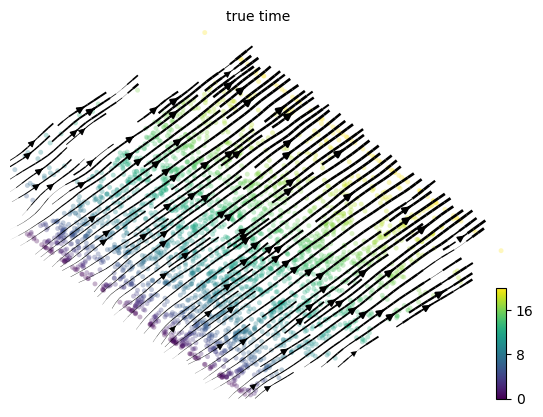

In [15]:
adata.obsm['velocity_spatial'] = adata.obsm['true_spatial_velocity']
scv.pl.velocity_embedding_stream(adata, s=50, basis='spatial', color='true_time', cutoff_perc=0)

# Bidirectional

In [16]:
n_cell = 3000
n_gene = 500
n_init_cell = 60
n_repress_gene = 100
angle = np.pi / 4
sparsity = (0.75, 0.75)
adata = simulation(n_cell,
                   n_gene,
                   n_init_cell,
                   n_repress_gene,
                   sparsity,
                   angle,
                   growth_type='1d (bidirection)',
                   v0=(0.01, 0.01),
                   noise_level=0.1,
                   velocity_model='linear',
                   rho_spatial_pattern='Gaussian (Bidirection)')

In [17]:
adata.write_h5ad('/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation/bilinear.h5ad')

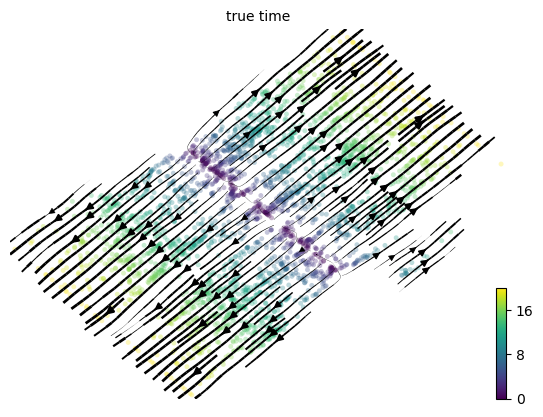

In [18]:
adata.obsm['velocity_spatial'] = adata.obsm['true_spatial_velocity']
scv.pl.velocity_embedding_stream(adata, s=50, basis='spatial', color='true_time', cutoff_perc=0)

# Radial Growth

In [19]:
n_cell = 3000
n_gene = 500
n_init_cell = 100
n_repress_gene = 100
angle = np.pi / 4
sparsity = (0.75, 0.75)
adata = simulation(n_cell,
                   n_gene,
                   n_init_cell,
                   n_repress_gene,
                   sparsity,
                   angle,
                   noise_level=0.1,
                   growth_type='radial',
                   velocity_model='linear',
                   rho_spatial_pattern='Polar Gaussian')

In [20]:
adata.write_h5ad('/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation/radial.h5ad')

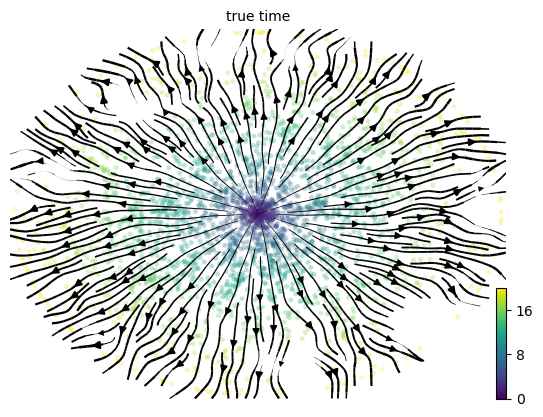

In [21]:
adata.obsm['velocity_spatial'] = adata.obsm['true_spatial_velocity']
scv.pl.velocity_embedding_stream(adata, s=50, basis='spatial', color='true_time', cutoff_perc=0)

# Multiple Radial

In [22]:
n_cell = 12000
n_gene = 500
n_init_cell = 400
n_repress_gene = 100
angle = np.pi / 4
centers = np.array([[np.sqrt(2)/2, np.sqrt(2)/2],
                    [-np.sqrt(2)/2, np.sqrt(2)/2],
                    [-np.sqrt(2)/2, -np.sqrt(2)/2],
                    [np.sqrt(2)/2, -np.sqrt(2)/2]])
sparsity = (0.75, 0.75)
adata = simulation(n_cell,
                   n_gene,
                   n_init_cell,
                   n_repress_gene,
                   sparsity,
                   angle,
                   noise_level=0.1,
                   growth_type='multi-radial',
                   velocity_model='linear',
                   rho_spatial_pattern='Polar Gaussian',
                   n_part=4,
                   centers=centers)

In [23]:
adata.write_h5ad('/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation/multiradial.h5ad')

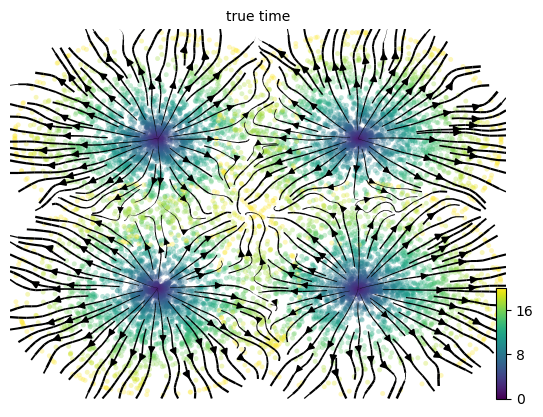

In [24]:
adata.obsm['velocity_spatial'] = adata.obsm['true_spatial_velocity']
scv.pl.velocity_embedding_stream(adata, s=50, basis='spatial', color='true_time', cutoff_perc=0)

# Multi-Slice Data

In [43]:
n_slice = 4
n_cell = 8000
n_gene = 500
n_init_cell = 60
d = 0.25
n_repress_gene = 100
angle = np.pi / 4
sparsity = (0.75, 0.75)
adata = simulation_multislice(n_slice,
                              n_cell,
                              n_gene,
                              n_init_cell,
                              n_repress_gene,
                              sparsity,
                              angle,
                              d=d,
                              growth_type='1d (bidirection)',
                              v0=(0.01, 0.01),
                              noise_level=0.1,
                              velocity_model='linear',
                              rho_spatial_pattern='Gaussian (Bidirection)')

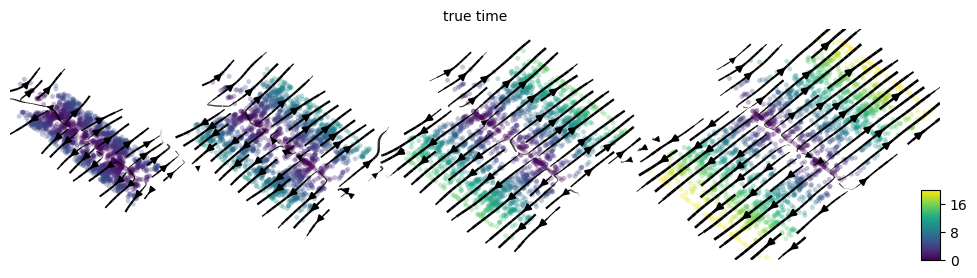

In [44]:
adata.obsm['velocity_spatial'] = adata.obsm['true_spatial_velocity']
scv.pl.velocity_embedding_stream(adata, s=50, basis='spatial', color='true_time', cutoff_perc=0, figsize=(12, 3))

In [45]:
adata.write_h5ad('/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation/bilinear_4slice.h5ad')

# Plot simulated genes

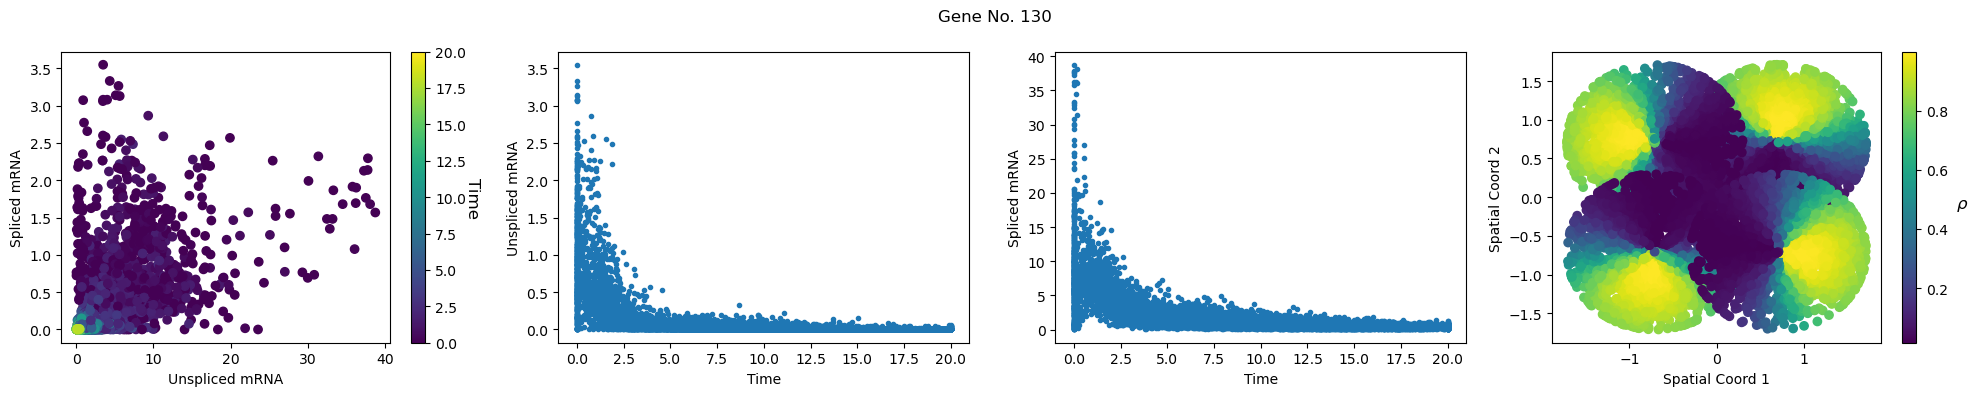

In [35]:
gidx = np.random.choice(adata.n_vars)
# gidx=423
u, s = adata.layers['Mu'][:, gidx], adata.layers['Ms'][:, gidx]
rho = adata.layers['true_rho'][:, gidx]
t = adata.obs['true_time'].to_numpy()
coords = adata.obsm['X_spatial']
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].scatter(s, u, c=t)
ax[1].plot(t, u, '.')
ax[2].plot(t, s, '.')
ax[3].scatter(coords[:, 0], coords[:, 1], c=rho)
ax[0].set_xlabel('Unspliced mRNA')
ax[0].set_ylabel('Spliced mRNA')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Unspliced mRNA')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Spliced mRNA')
ax[3].set_xlabel('Spatial Coord 1')
ax[3].set_ylabel('Spatial Coord 2')
norm_t = matplotlib.colors.Normalize(vmin=t.min(), vmax=t.max())
sm_t = matplotlib.cm.ScalarMappable(norm=norm_t)
cbar_t = plt.colorbar(sm_t, ax=ax[0])
cbar_t.ax.get_yaxis().labelpad = 10
cbar_t.ax.set_ylabel('Time', rotation=270, fontsize=12)

norm_rho = matplotlib.colors.Normalize(vmin=rho.min(), vmax=rho.max())
sm_rho = matplotlib.cm.ScalarMappable(norm=norm_rho)
cbar_rho = plt.colorbar(sm_rho, ax=ax[3])
cbar_rho.ax.get_yaxis().labelpad = 10
cbar_rho.ax.set_ylabel(r'$\rho$', rotation=0, fontsize=12)
fig.suptitle(f'Gene No. {gidx+1}')
plt.tight_layout()
plt.show()

# 1D linear dataset used for time and memory profiling

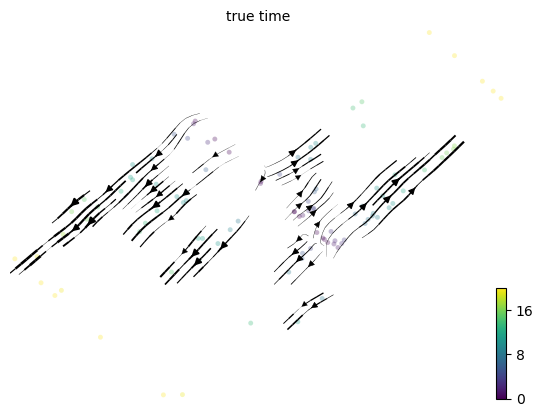

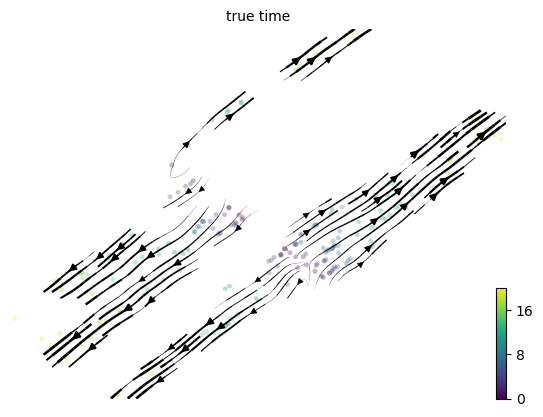

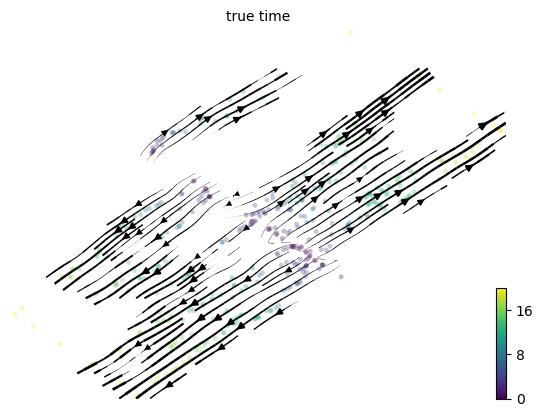

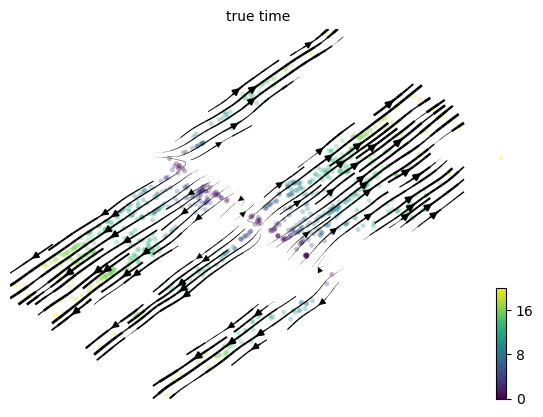

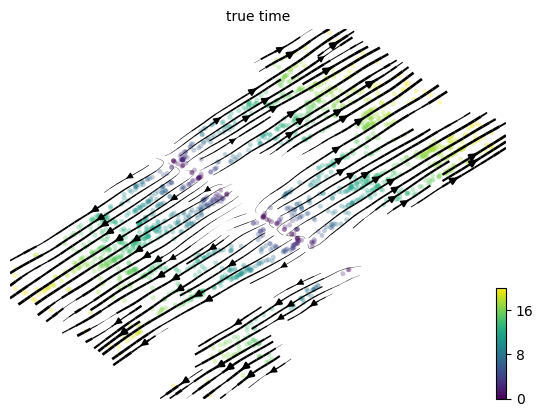

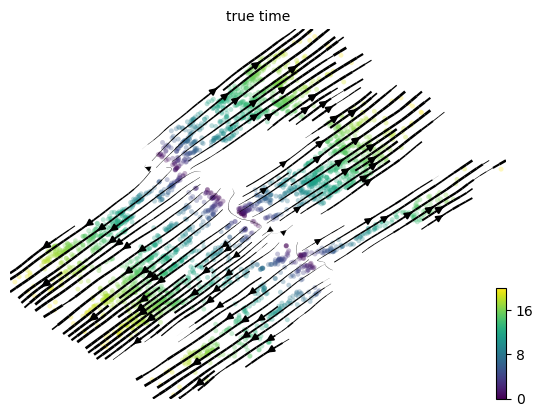

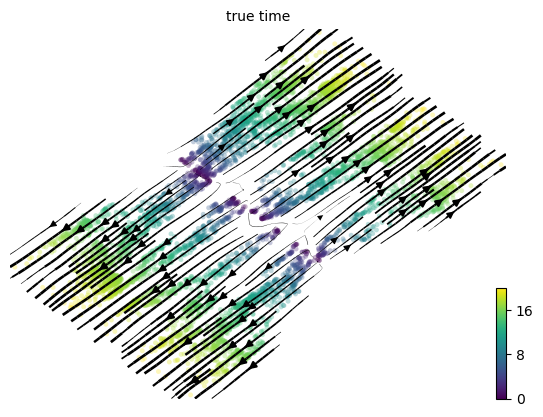

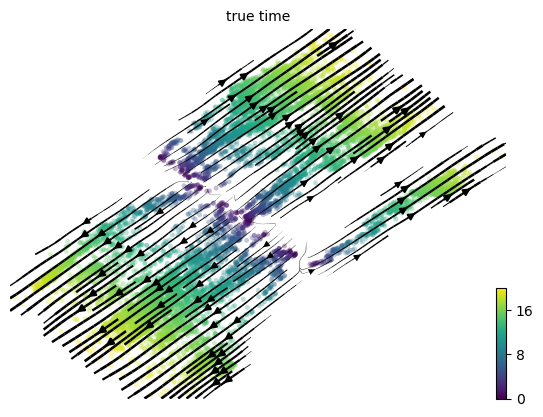

In [12]:
n_cell_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
n_init_cell_list = [10, 12, 14, 16, 20, 23, 26, 29, 35, 50]
for n_cell, n_init_cell in zip(n_cell_list, n_init_cell_list):
    np.random.seed(42)
    n_gene = 500
    n_repress_gene = 100
    angle = np.pi / 4
    sparsity = (0.9, 0.9)
    adata = simulation(n_cell,
                       n_gene,
                       n_init_cell,
                       n_repress_gene,
                       sparsity,
                       angle,
                       growth_type='1d (bidirection)',
                       v0=(0.01, 0.01),
                       noise_level=0.1,
                       velocity_model='linear',
                       rho_spatial_pattern='Gaussian (Bidirection)')
    adata.obsm['velocity_spatial'] = adata.obsm['true_spatial_velocity']
    scv.pl.velocity_embedding_stream(adata, s=50, basis='spatial', color='true_time', cutoff_perc=0)
    adata.write_h5ad(f'/nfs/turbo/umms-welchjd/yichen/data/topovelo/simulation/sim_{n_cell}.h5ad')
    del adata